In [23]:
import time
from pennylane import numpy as np 

st = time.time()
np.random.seed(12345678)

# Technology Laboratory: Exploring Quantum Signal Processing and the Quantum Singular Value Transformation

**James D Whitfield**  
Amazon Visiting Academic  
Dartmouth College

**Jay Soni**  
Quantum Software Developer  
XanaduAI

Instructor: James Whitfield (james.d.whitfield@dartmouth.edu), Amazon Visiting Academic;

## Introduction 

The Quantum Singular Value Transformation (QSVT) algorithm [1] allows us to transform the singular values of a matrix **without** the need for explicit diagonalization. It's a very versatile framework that can be used to recover some of the most famous algorithms in quantum computing (search, hamiltonian simulation, factoring)[2]. In this laboratory, we will explore the concept of Quantum Signal Processing (QSP) that underpins QSVT, then we will use this concept to build a polynomial function approximator. We will then learn about qubitization and use it to generalize the QSP theorem to QSVT! Finally, we will take all we have learned and apply it to solve the unstructured search problem.

Additionally, this lab will be using PennyLane to generate and execute quantum circuits. If you don't have PennyLane installed on your machine, please follow the installation instructions [here](https://pennylane.ai/install/).

## Outline
1. **Reflections, Rotations and ... Polynomials?**
    - A. Build Intuition 
    - B. Code Example
    - C. QSP Theorem 
2. **Its Fun Fitting Functions!**
    - A. Learning phase angles on the Fly 
    - B. QSP as a polynomial function approximator
    - C. Recovering the right Unitary 
3. **Qubitized, Factorized and Generalized:**
    - A. Theory (Qubitized subspaces with walk operators) 
    - B. QSVT Theorem
    - C. Summary ^^ (why QSVT is essentially a tensorized QSP)
5. **Grover Search with QSVT**
    - A. Problem statement 
    - B. Applying the theorem in code! 
6. **References**

## 1. Reflections, Rotations and ... Polynomials? 

### 1.A Building Intuition 





### 1.C Quantum Signal Processing Theorem



### 1.B Code Example

In [24]:
# Code example: 
import pennylane as qml
from pennylane import numpy as np

def W(a):
    diag, off_diag = (a, (1 - a**2) ** (1 / 2) * 1j)
    W_a = [[diag,     off_diag], 
           [off_diag,     diag]]

    return np.array(W_a)


def U_qsp(a, phase_angles):
    phi_0, W_mat = (phase_angles[0], W(a))    
    res = np.diag([np.exp(1j*phi_0), np.exp(-1j*phi_0)])
    
    for phi_i in phase_angles[1:]:    
        res = res @ W_mat @ np.diag([np.exp(1j*phi_i), np.exp(-1j*phi_i)])
    
    return res


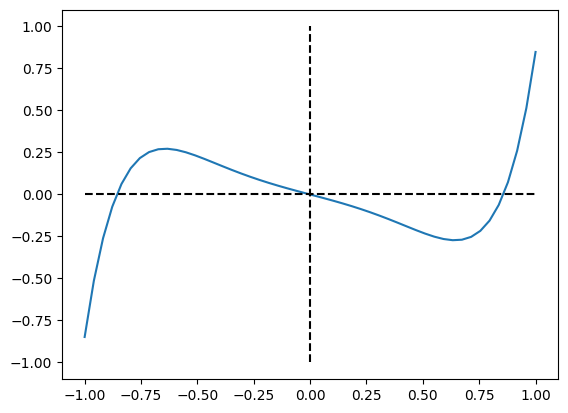

In [25]:
import matplotlib.pyplot as plt

degree = 7
a_vals = np.linspace(-1, 1, 50)
phi_vals = (2*np.random.rand(degree + 1) - 1) * np.pi  # sample "degree+1"-many phase angles from (-pi, pi)

poly_a = np.array([U_qsp(a, phi_vals)[0,0] for a in a_vals])

plt.plot(a_vals, np.real(poly_a))
plt.vlines(0.0, -1.0, 1.0, color="black", linestyle="--")
plt.hlines(0.0, -1.0, 1.0, color="black", linestyle="--")
plt.show()

#### Exercies: 

- ***Exercies 1.1:*** What is the polynomial $P(a)$ constructed for a QSP circuit with phase angles $\vec{\phi} = (\frac{\pi}{4}, -\frac{\pi}{2}, 0)$?
- ***Exercies 1.2:*** Solve for the phase angles $(\vec{\phi} \in \mathbb{R}^3)$ that would generate a polynomial $P(a) = 1 - 2a^2$?
- ***Exercies 1.3:*** For both of the questions above, verify your solution by using the code above to plot the theoretical polynomial against the one generated using QSP.

## 2. Its Fun Fitting Functions!

### 2.A Learning phase angles on the Fly

In [26]:
## Train a QSP circuit to fit a given polynomial function 

def target_func(x): 
    return x**5 - 3*x**3 + x  

def loss_func(phi_vals):
    num_samples = 25
    
    loss = 0
    for a in np.linspace(-1, 1, num_samples):
        qsp_poly_a = qml.matrix(qml.qsvt(a, phi_vals, wires=[0]))[0,0]
        loss += (np.real(qsp_poly_a) - target_func(a))**2

    return loss / num_samples 

In [27]:
# Optimization:
cost = 1
iteration = 0
opt = qml.AdagradOptimizer(0.1)

phi_vals = np.random.rand(6)
initial_phi = phi_vals

while cost > 1e-5:
    iteration += 1
    phi_vals, cost = opt.step_and_cost(loss_func, phi_vals)

    if iteration % 10 == 0 or iteration == 1:
        print(f"iter: {iteration}, cost: {cost}")

    if iteration > 100:
        print("Iteration limit reached!")
        break

print(f"Completed Optimization! (final cost: {cost})")

iter: 1, cost: 0.2021703383164453
iter: 10, cost: 0.005821968635971699
iter: 20, cost: 0.004233078108765612
iter: 30, cost: 0.0032841097452720926
iter: 40, cost: 0.0026140731927622534
iter: 50, cost: 0.002109636543240061
iter: 60, cost: 0.0017086503621049928
iter: 70, cost: 0.001377235933121716
iter: 80, cost: 0.0010985282429100463
iter: 90, cost: 0.0008646351013089876
iter: 100, cost: 0.0006713219509804279
Iteration limit reached!
Completed Optimization! (final cost: 0.0006540884092065552)


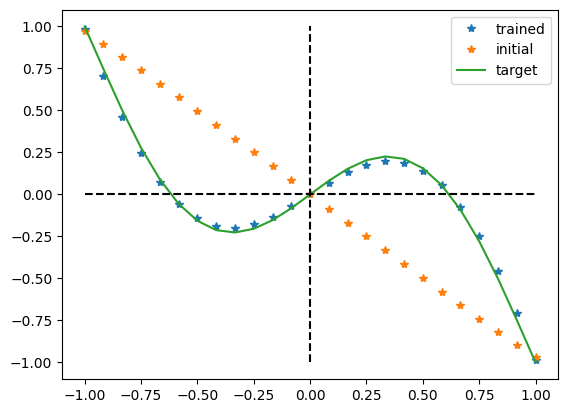

In [28]:
a_vals = np.linspace(-1, 1, 25)

trained_poly = [qml.matrix(qml.qsvt(a, phi_vals, wires=[0]))[0,0] for a in a_vals]
initial_poly = [qml.matrix(qml.qsvt(a, initial_phi, wires=[0]))[0,0] for a in a_vals]
targeted_poly = [target_func(a) for a in a_vals]

plt.plot(a_vals, trained_poly, "*", label="trained")
plt.plot(a_vals, initial_poly, "*", label="initial")
plt.plot(a_vals, targeted_poly, label="target")

plt.vlines(0.0, -1.0, 1.0, color="black", linestyle="--")
plt.hlines(0.0, -1.0, 1.0, color="black", linestyle="--")

plt.legend()
plt.show()

### 2.B QSP as a polynomial function approximator

In [29]:
## Train a QSP circuit to fit the heaviside step function 

def target_func(x): 
    return 1 if x>0 else -1

def loss_func(phi_vals):
    num_samples = 50
    
    loss = 0
    for a in np.linspace(-1, 1, num_samples):
        qsp_poly_a = qml.matrix(qml.qsvt(a, phi_vals, wires=[0]))[0,0]
        loss += (np.real(qsp_poly_a) - target_func(a))**2

    return loss / num_samples 


# Optimization:
cost = 1
iteration = 0
opt = qml.AdagradOptimizer(0.1)

phi_vals = np.random.rand(14)  # (d+1) has to be even since P(a) must be odd to fit 
initial_phi = phi_vals         #     the step function.

while cost > 1e-5:
    iteration += 1
    phi_vals, cost = opt.step_and_cost(loss_func, phi_vals)

    if iteration % 10 == 0 or iteration == 1:
        print(f"iter: {iteration}, cost: {cost}")

    if iteration > 100:
        print("Iteration limit reached!")
        break

print(f"Completed Optimization! (final cost: {cost})")

iter: 1, cost: 0.7148173982080668
iter: 10, cost: 0.13690088251340346
iter: 20, cost: 0.11523408401861028
iter: 30, cost: 0.10498909953673362
iter: 40, cost: 0.09820905659682376
iter: 50, cost: 0.09373396495314695
iter: 60, cost: 0.09079327021064287
iter: 70, cost: 0.08881978643461284
iter: 80, cost: 0.0874482159192603
iter: 90, cost: 0.08645762959411332
iter: 100, cost: 0.08571568254301157
Iteration limit reached!
Completed Optimization! (final cost: 0.08565174301101708)


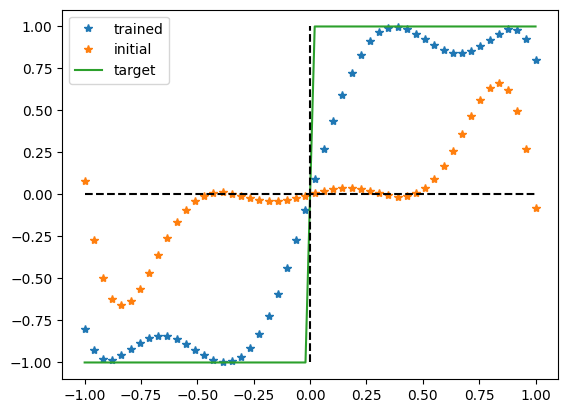

In [30]:
a_vals = np.linspace(-1, 1, 50)

trained_poly = [qml.matrix(qml.qsvt(a, phi_vals, wires=[0]))[0,0] for a in a_vals]
initial_poly = [qml.matrix(qml.qsvt(a, initial_phi, wires=[0]))[0,0] for a in a_vals]
targeted_poly = [target_func(a) for a in a_vals]

plt.plot(a_vals, trained_poly, "*", label="trained")
plt.plot(a_vals, initial_poly, "*", label="initial")
plt.plot(a_vals, targeted_poly, label="target")

plt.vlines(0.0, -1.0, 1.0, color="black", linestyle="--")
plt.hlines(0.0, -1.0, 1.0, color="black", linestyle="--")

plt.legend()
plt.show()

### 2.C Recovering the right Unitary

In [ ]:
## Show how to recover the "real" unitary

#### Exercies: 

- ***Exercies 2.1:*** Using the code above as a reference, can you find the phase angles to approximate $f(x) = sin(x)$?
- ***Exercies 2.2:*** Using the code above as a reference, can you find the phase angles to approximate $g(x) = cos(x)$?

***Bonus:*** Construct a circuit using the phase angles you computed above to perform the transformation below: (hint: use the method of LCUs) $$h(x) \approx e^{ix} = cos(x) + i*sin(x)$$

*Note:* The circuit you just created can be used to perform hamiltonian time evolution $e^{-iHt}$. This is another powerful application of QSP/QSVT.

#### Solutions: (Remove this cell before sending to students)




## 3. Qubitized, Factorized and Generalized:

### 3.A Theory of Qubitization

### 3.B Generalization of QSP to QSVT 

### 3.C Summary? 

In [35]:
eigvals = np.linspace(-1, 1, 16)
A = np.diag(eigvals)  # 16-dim matrix
print(np.diagonal(A))

wire_order = list(range(5))
U_A = qml.matrix(qml.qsvt, wire_order=wire_order)(A, phi_vals, wires=wire_order)  # block-encoded in 5-qubit system
qsvt_A = np.real(np.diagonal(U_A))[:16]  # retrieve transformed eigenvalues
print(qsvt_A)

[-1.         -0.86666667 -0.73333333 -0.6        -0.46666667 -0.33333333
 -0.2        -0.06666667  0.06666667  0.2         0.33333333  0.46666667
  0.6         0.73333333  0.86666667  1.        ]
[-0.79830795 -0.97940532 -0.86482195 -0.85516543 -0.95923453 -0.98674524
 -0.76891813 -0.29252645  0.29252645  0.76891813  0.98674524  0.95923453
  0.85516543  0.86482195  0.97940532  0.79830795]


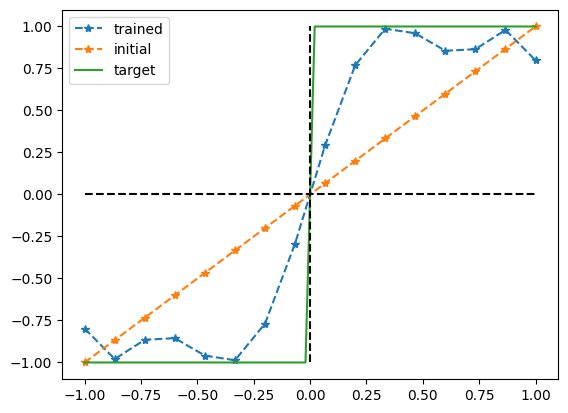

In [40]:
plt.plot(eigvals, qsvt_A, "--*", label="trained")
plt.plot(eigvals, np.diagonal(A), "--*", label="initial")
plt.plot(a_vals, targeted_poly, label="target")


plt.vlines(0.0, -1.0, 1.0, color="black", linestyle="--")
plt.hlines(0.0, -1.0, 1.0, color="black", linestyle="--")

plt.legend()
plt.show()

## 4. Grover Search with QSVT

### 4.A A connection to Grover

### 4.B Coding Application

In [ ]:
def pi_m_not(work_wires, control_wire, marked):

def Projector_ctrl_not():

## 5. References:

- [1] András Gilyén, Yuan Su, Guang Hao Low, Nathan Wiebe, “Quantum singular value transformation and beyond: exponential improvements for quantum matrix arithmetics”, Proceedings of the 51st Annual ACM SIGACT Symposium on the Theory of Computing, 2019
- [2] John M. Martyn, Zane M. Rossi, Andrew K. Tan, and Isaac L. Chuang, “Grand Unification of Quantum Algorithms”, PRX Quantum 2, 040203, 2021
-  


In [ ]:
et = time.time()
print("Execution time for notebook: ",et-st, " seconds")